# Disease Classifier Training - Unified

This notebook consolidates disease classifier training and hierarchical ensemble:

## Contents
1. **Part 1: Data Loading & Preparation** - Load datasets, filter, and split
2. **Part 2: Base Classifier Training** - Category and Disease classifiers
3. **Part 3: Performance Comparison** - Original vs Demographics
4. **Part 4: Hierarchical Ensemble** - Specialist models with Top-K routing
5. **Part 5: Save Models** - Export all trained models
6. **Part 6: End-to-End Test** - Full pipeline demonstration

**Models:**
- Category Classifier (multi-class)
- Disease Classifier (multi-class)
- Specialist Models (14 category-specific classifiers)

**Key Fix**: Filters out diseases with < 5 samples and stratifies by disease (not category) to ensure all diseases appear in train/val/test splits.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, top_k_accuracy_score
from sklearn.preprocessing import LabelEncoder

import sys, os, json, joblib, warnings, time
warnings.filterwarnings('ignore')

# Adding the project root to path
project_root = Path(os.getcwd()).parent.parent  
sys.path.insert(0, str(project_root))

print(f"Project root: {project_root}")

Project root: c:\Users\henry\Desktop\Programming\Python\Multimodal_Diagnosis


In [2]:
# Configuration
MIN_SAMPLES_PER_DISEASE = 5  # Minimum samples required per disease
RANDOM_STATE = 42
TEST_SIZE = 0.1
VAL_SIZE = 0.111  # ~10% of remaining 90%

print(f"Minimum samples per disease: {MIN_SAMPLES_PER_DISEASE}")
print(f"Split: 80% train, 10% val, 10% test")

Minimum samples per disease: 5
Split: 80% train, 10% val, 10% test


---
# Part 1: Data Loading & Preparation

## 1.1 Load and Filter Original Data

In [3]:
# Load original dataset
data_path_original = project_root / "data" / "processed" / "symptoms" / "symptoms_augmented_no_demographics.csv"
df_original_raw = pd.read_csv(data_path_original)

print(f"Raw Dataset: {df_original_raw.shape}")
print(f"Samples: {len(df_original_raw):,}")
print(f"Diseases: {df_original_raw['diseases'].nunique()}")
print(f"Categories: {df_original_raw['disease_category'].nunique()}")

Raw Dataset: (223944, 456)
Samples: 223,944
Diseases: 667
Categories: 14


In [4]:
# Filter out rare diseases (< MIN_SAMPLES_PER_DISEASE samples)
disease_counts = df_original_raw['diseases'].value_counts()
valid_diseases = disease_counts[disease_counts >= MIN_SAMPLES_PER_DISEASE].index
df_original = df_original_raw[df_original_raw['diseases'].isin(valid_diseases)].reset_index(drop=True)

removed_diseases = df_original_raw['diseases'].nunique() - df_original['diseases'].nunique()
removed_samples = len(df_original_raw) - len(df_original)

print(f"\nAfter filtering (min {MIN_SAMPLES_PER_DISEASE} samples):")
print(f"  Samples: {len(df_original):,} (removed {removed_samples:,})")
print(f"  Diseases: {df_original['diseases'].nunique()} (removed {removed_diseases})")
print(f"  Categories: {df_original['disease_category'].nunique()}")


After filtering (min 5 samples):
  Samples: 223,920 (removed 24)
  Diseases: 656 (removed 11)
  Categories: 14


In [5]:
# Show removed diseases
rare_diseases = disease_counts[disease_counts < MIN_SAMPLES_PER_DISEASE]
print(f"Rare diseases removed ({len(rare_diseases)}):")
for disease, count in rare_diseases.items():
    print(f"  - {disease}: {count} samples")

Rare diseases removed (11):
  - oral leukoplakia: 4 samples
  - intussusception: 4 samples
  - esophageal varices: 3 samples
  - hyperlipidemia: 3 samples
  - obesity: 3 samples
  - carcinoid syndrome: 2 samples
  - turner syndrome: 1 samples
  - hypergammaglobulinemia: 1 samples
  - huntington disease: 1 samples
  - high blood pressure: 1 samples
  - diabetes: 1 samples


## 1.2 Prepare Features and Labels

In [6]:
# Get feature columns (symptoms only)
non_feature_cols = ['diseases', 'disease_category', 'symptoms', 'age', 'sex']
symptom_cols = [col for col in df_original.columns if col not in non_feature_cols]

print(f"Symptom features: {len(symptom_cols)}")

# Features and labels
X_orig = df_original[symptom_cols].values
y_category = df_original['disease_category'].values
y_disease = df_original['diseases'].values

# Encode labels on FULL dataset before splitting
category_encoder = LabelEncoder()
disease_encoder = LabelEncoder()
y_cat_encoded = category_encoder.fit_transform(y_category)
y_dis_encoded = disease_encoder.fit_transform(y_disease)

print(f"X shape: {X_orig.shape}")
print(f"Categories: {len(category_encoder.classes_)}")
print(f"Diseases: {len(disease_encoder.classes_)}")

Symptom features: 454
X shape: (223920, 454)
Categories: 14
Diseases: 656


## 1.3 Train/Val/Test Split (Original)

In [7]:
# Split: 80% train, 10% val, 10% test
# KEY FIX: Stratify by DISEASE (not category) to ensure all diseases in each split

X_temp, X_test_orig, y_cat_temp, y_cat_test, y_dis_temp, y_dis_test = train_test_split(
    X_orig, y_cat_encoded, y_dis_encoded, 
    test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_dis_encoded
)

X_train_orig, X_val_orig, y_cat_train, y_cat_val, y_dis_train, y_dis_val = train_test_split(
    X_temp, y_cat_temp, y_dis_temp,
    test_size=VAL_SIZE, random_state=RANDOM_STATE, stratify=y_dis_temp
)

print(f"Train: {len(X_train_orig):,} | Val: {len(X_val_orig):,} | Test: {len(X_test_orig):,}")

# Verify all disease labels are in training set
train_diseases = set(y_dis_train)
val_diseases = set(y_dis_val)
test_diseases = set(y_dis_test)
missing_in_train = (val_diseases | test_diseases) - train_diseases
if missing_in_train:
    print(f"WARNING: {len(missing_in_train)} diseases missing from training set!")
else:
    print("✓ All disease labels present in training set.")

Train: 179,158 | Val: 22,370 | Test: 22,392
✓ All disease labels present in training set.


## 1.4 Load Demographics Data

In [8]:
# Load the demographics-augmented data
data_path_demo = project_root / "data" / "processed" / "symptoms" / "symptoms_augmented_with_demographics.csv"
df_demo = pd.read_csv(data_path_demo)

# Filter to same diseases as original (which are already filtered for min samples)
valid_diseases_set = set(df_original['diseases'].unique())
df_demo = df_demo[df_demo['diseases'].isin(valid_diseases_set)].reset_index(drop=True)

print(f"Demographics Dataset (filtered): {df_demo.shape}")
print(f"Has 'age': {'age' in df_demo.columns}")
print(f"Has 'sex': {'sex' in df_demo.columns}")
print(f"Age range: {df_demo['age'].min()} - {df_demo['age'].max()}")
print(f"Sex distribution: {df_demo['sex'].value_counts().to_dict()}")

Demographics Dataset (filtered): (223920, 458)
Has 'age': True
Has 'sex': True
Age range: 0 - 98
Sex distribution: {'F': 116572, 'M': 107348}


In [9]:
# Prepare features with demographics
# Encode sex as binary (M=1, F=0)
df_demo['sex_encoded'] = (df_demo['sex'] == 'M').astype(int)

# Normalize age to 0-1 range
df_demo['age_normalized'] = df_demo['age'] / 100.0

# Feature columns: symptoms + age + sex
demo_feature_cols = symptom_cols + ['age_normalized', 'sex_encoded']

X_demo = df_demo[demo_feature_cols].values
print(f"Features with demographics: {X_demo.shape[1]} (symptoms: {len(symptom_cols)}, demo: 2)")

Features with demographics: 456 (symptoms: 454, demo: 2)


## 1.5 Train/Val/Test Split (Demographics)

In [10]:
# Use same encoders (already fit on original data)
y_cat_demo = category_encoder.transform(df_demo['disease_category'].values)
y_dis_demo = disease_encoder.transform(df_demo['diseases'].values)

# Split with stratification by DISEASE
X_temp_d, X_test_demo, y_cat_temp_d, y_cat_test_d, y_dis_temp_d, y_dis_test_d = train_test_split(
    X_demo, y_cat_demo, y_dis_demo,
    test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_dis_demo
)

X_train_demo, X_val_demo, y_cat_train_d, y_cat_val_d, y_dis_train_d, y_dis_val_d = train_test_split(
    X_temp_d, y_cat_temp_d, y_dis_temp_d,
    test_size=VAL_SIZE, random_state=RANDOM_STATE, stratify=y_dis_temp_d
)

print(f"Train: {len(X_train_demo):,} | Val: {len(X_val_demo):,} | Test: {len(X_test_demo):,}")

# Verify splits
train_diseases_d = set(y_dis_train_d)
val_diseases_d = set(y_dis_val_d)
test_diseases_d = set(y_dis_test_d)
missing_demo = (val_diseases_d | test_diseases_d) - train_diseases_d
if missing_demo:
    print(f"WARNING: {len(missing_demo)} diseases missing from training set!")
else:
    print("✓ All disease labels present in training set.")

Train: 179,158 | Val: 22,370 | Test: 22,392
✓ All disease labels present in training set.


---
# Part 2: Base Classifier Training

## 2.1 Train Category Classifier (Original)

In [11]:
from models.architectures.symptom_classifier import SymptomCategoryClassifier, SymptomDiseaseClassifier

# Train category classifier
cat_clf_orig = SymptomCategoryClassifier(
    n_estimators=200, learning_rate=0.05, max_depth=7, class_weight='balanced', stopping_rounds=50
)

print("Training Category Classifier (Original)...")
cat_clf_orig.fit(X_train_orig, y_cat_train, eval_set=[(X_val_orig, y_cat_val)])
print("Done!")

Training Category Classifier (Original)...
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's multi_logloss: 0.336153
Done!


In [12]:
# Evaluate Category Classifier
y_cat_pred_orig = cat_clf_orig.predict(X_test_orig)
y_cat_proba_orig = cat_clf_orig.predict_proba(X_test_orig)

cat_acc_orig = accuracy_score(y_cat_test, y_cat_pred_orig)
cat_top3_orig = top_k_accuracy_score(y_cat_test, y_cat_proba_orig, k=3)
cat_top5_orig = top_k_accuracy_score(y_cat_test, y_cat_proba_orig, k=5)

print("CATEGORY CLASSIFIER (Original - Symptoms Only)")
print("="*50)
print(f"Top-1: {cat_acc_orig*100:.2f}%")
print(f"Top-3: {cat_top3_orig*100:.2f}%")
print(f"Top-5: {cat_top5_orig*100:.2f}%")

CATEGORY CLASSIFIER (Original - Symptoms Only)
Top-1: 89.95%
Top-3: 99.21%
Top-5: 99.71%


## 2.2 Train Disease Classifier (Original)

In [13]:
# Train disease classifier
dis_clf_orig = SymptomDiseaseClassifier(
    category="all", n_estimators=300, learning_rate=0.05, max_depth=10, stopping_rounds=50
)

print("Training Disease Classifier (Original)...")
dis_clf_orig.fit(X_train_orig, y_dis_train, eval_set=[(X_val_orig, y_dis_val)])
print("Done!")

Training Disease Classifier (Original)...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 2.30254
Done!


In [14]:
# Evaluate Disease Classifier
y_dis_pred_orig = dis_clf_orig.predict(X_test_orig)
y_dis_proba_orig = dis_clf_orig.predict_proba(X_test_orig)

all_labels = np.arange(len(disease_encoder.classes_))

dis_acc_orig = accuracy_score(y_dis_test, y_dis_pred_orig)
dis_top3_orig = top_k_accuracy_score(y_dis_test, y_dis_proba_orig, k=3, labels=all_labels)
dis_top5_orig = top_k_accuracy_score(y_dis_test, y_dis_proba_orig, k=5, labels=all_labels)
dis_top10_orig = top_k_accuracy_score(y_dis_test, y_dis_proba_orig, k=10, labels=all_labels)

print("DISEASE CLASSIFIER (Original - Symptoms Only)")
print("="*50)
print(f"Top-1:  {dis_acc_orig*100:.2f}%")
print(f"Top-3:  {dis_top3_orig*100:.2f}%")
print(f"Top-5:  {dis_top5_orig*100:.2f}%")
print(f"Top-10: {dis_top10_orig*100:.2f}%")

DISEASE CLASSIFIER (Original - Symptoms Only)
Top-1:  75.17%
Top-3:  87.21%
Top-5:  89.77%
Top-10: 92.42%


## 2.3 Train Category Classifier (Demographics)

In [15]:
# Train category classifier with demographics
cat_clf_demo = SymptomCategoryClassifier(
    n_estimators=200, learning_rate=0.05, max_depth=7, class_weight='balanced', stopping_rounds=50
)

print("Training Category Classifier (Demographics)...")
cat_clf_demo.fit(X_train_demo, y_cat_train_d, eval_set=[(X_val_demo, y_cat_val_d)])
print("Done!")

Training Category Classifier (Demographics)...
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[200]	valid_0's multi_logloss: 0.31318
Done!


In [16]:
# Evaluate
y_cat_pred_demo = cat_clf_demo.predict(X_test_demo)
y_cat_proba_demo = cat_clf_demo.predict_proba(X_test_demo)

cat_acc_demo = accuracy_score(y_cat_test_d, y_cat_pred_demo)
cat_top3_demo = top_k_accuracy_score(y_cat_test_d, y_cat_proba_demo, k=3)
cat_top5_demo = top_k_accuracy_score(y_cat_test_d, y_cat_proba_demo, k=5)

print("CATEGORY CLASSIFIER (Demographics - Symptoms + Age + Sex)")
print("="*50)
print(f"Top-1: {cat_acc_demo*100:.2f}%")
print(f"Top-3: {cat_top3_demo*100:.2f}%")
print(f"Top-5: {cat_top5_demo*100:.2f}%")

CATEGORY CLASSIFIER (Demographics - Symptoms + Age + Sex)
Top-1: 90.71%
Top-3: 99.29%
Top-5: 99.79%


## 2.4 Train Disease Classifier (Demographics)

In [17]:
# Train disease classifier with demographics
dis_clf_demo = SymptomDiseaseClassifier(
    category="all", n_estimators=300, learning_rate=0.05, max_depth=10, stopping_rounds=50
)

print("Training Disease Classifier (Demographics)...")
dis_clf_demo.fit(X_train_demo, y_dis_train_d, eval_set=[(X_val_demo, y_dis_val_d)])
print("Done!")

Training Disease Classifier (Demographics)...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's multi_logloss: 2.22703
Done!


In [18]:
# Evaluate
y_dis_pred_demo = dis_clf_demo.predict(X_test_demo)
y_dis_proba_demo = dis_clf_demo.predict_proba(X_test_demo)

dis_acc_demo = accuracy_score(y_dis_test_d, y_dis_pred_demo)
dis_top3_demo = top_k_accuracy_score(y_dis_test_d, y_dis_proba_demo, k=3, labels=all_labels)
dis_top5_demo = top_k_accuracy_score(y_dis_test_d, y_dis_proba_demo, k=5, labels=all_labels)
dis_top10_demo = top_k_accuracy_score(y_dis_test_d, y_dis_proba_demo, k=10, labels=all_labels)

print("DISEASE CLASSIFIER (Demographics - Symptoms + Age + Sex)")
print("="*50)
print(f"Top-1:  {dis_acc_demo*100:.2f}%")
print(f"Top-3:  {dis_top3_demo*100:.2f}%")
print(f"Top-5:  {dis_top5_demo*100:.2f}%")
print(f"Top-10: {dis_top10_demo*100:.2f}%")

DISEASE CLASSIFIER (Demographics - Symptoms + Age + Sex)
Top-1:  77.09%
Top-3:  87.19%
Top-5:  89.51%
Top-10: 91.30%


---
# Part 3: Performance Comparison

In [19]:
# Create comparison table
print("="*80)
print("PERFORMANCE COMPARISON: Original vs Demographics")
print("="*80)

print("\n" + "-"*80)
print("CATEGORY CLASSIFIER")
print("-"*80)
print(f"{'Metric':<15} {'Original (Symptoms)':<25} {'+ Demographics':<25} {'Improvement':<15}")
print("-"*80)
print(f"{'Top-1':<15} {cat_acc_orig*100:>20.2f}% {cat_acc_demo*100:>20.2f}% {(cat_acc_demo-cat_acc_orig)*100:>+12.2f}%")
print(f"{'Top-3':<15} {cat_top3_orig*100:>20.2f}% {cat_top3_demo*100:>20.2f}% {(cat_top3_demo-cat_top3_orig)*100:>+12.2f}%")
print(f"{'Top-5':<15} {cat_top5_orig*100:>20.2f}% {cat_top5_demo*100:>20.2f}% {(cat_top5_demo-cat_top5_orig)*100:>+12.2f}%")

n_diseases = len(disease_encoder.classes_)
print("\n" + "-"*80)
print(f"DISEASE CLASSIFIER ({n_diseases} classes)")
print("-"*80)
print(f"{'Metric':<15} {'Original (Symptoms)':<25} {'+ Demographics':<25} {'Improvement':<15}")
print("-"*80)
print(f"{'Top-1':<15} {dis_acc_orig*100:>20.2f}% {dis_acc_demo*100:>20.2f}% {(dis_acc_demo-dis_acc_orig)*100:>+12.2f}%")
print(f"{'Top-3':<15} {dis_top3_orig*100:>20.2f}% {dis_top3_demo*100:>20.2f}% {(dis_top3_demo-dis_top3_orig)*100:>+12.2f}%")
print(f"{'Top-5':<15} {dis_top5_orig*100:>20.2f}% {dis_top5_demo*100:>20.2f}% {(dis_top5_demo-dis_top5_orig)*100:>+12.2f}%")
print(f"{'Top-10':<15} {dis_top10_orig*100:>20.2f}% {dis_top10_demo*100:>20.2f}% {(dis_top10_demo-dis_top10_orig)*100:>+12.2f}%")

PERFORMANCE COMPARISON: Original vs Demographics

--------------------------------------------------------------------------------
CATEGORY CLASSIFIER
--------------------------------------------------------------------------------
Metric          Original (Symptoms)       + Demographics            Improvement    
--------------------------------------------------------------------------------
Top-1                          89.95%                90.71%        +0.75%
Top-3                          99.21%                99.29%        +0.08%
Top-5                          99.71%                99.79%        +0.08%

--------------------------------------------------------------------------------
DISEASE CLASSIFIER (656 classes)
--------------------------------------------------------------------------------
Metric          Original (Symptoms)       + Demographics            Improvement    
--------------------------------------------------------------------------------
Top-1               

In [20]:
# Test on specific demographic-sensitive diseases
print("\n" + "="*80)
print("DEMOGRAPHIC-SENSITIVE DISEASE ANALYSIS")
print("="*80)

# Select diseases where demographics matter
demo_sensitive = ["prostate cancer", "erectile dysfunction",
                  "alzheimer disease", "osteoporosis", "autism", "eating disorder"]

print(f"\n{'Disease':<30} {'Orig Acc':<12} {'Demo Acc':<12} {'Improvement':<12}")
print("-"*70)

for disease in demo_sensitive:
    if disease in disease_encoder.classes_:
        disease_idx = disease_encoder.transform([disease])[0]
        
        # Original: get test samples for this disease
        mask_orig = (y_dis_test == disease_idx)
        if mask_orig.sum() > 0:
            acc_orig = (y_dis_pred_orig[mask_orig] == disease_idx).mean()
        else:
            acc_orig = 0
        
        # Demographics
        mask_demo = (y_dis_test_d == disease_idx)
        if mask_demo.sum() > 0:
            acc_demo = (y_dis_pred_demo[mask_demo] == disease_idx).mean()
        else:
            acc_demo = 0
        
        improvement = acc_demo - acc_orig
        print(f"{disease:<30} {acc_orig*100:>8.1f}% {acc_demo*100:>8.1f}% {improvement*100:>+10.1f}%")
    else:
        print(f"{disease:<30} (not in dataset)")


DEMOGRAPHIC-SENSITIVE DISEASE ANALYSIS

Disease                        Orig Acc     Demo Acc     Improvement 
----------------------------------------------------------------------
prostate cancer                    92.3%     76.9%      -15.4%
erectile dysfunction               63.9%     78.7%      +14.8%
alzheimer disease                  97.1%     97.1%       +0.0%
osteoporosis                       78.9%     78.9%       +0.0%
autism                             88.9%     86.7%       -2.2%
eating disorder                    83.7%     85.7%       +2.0%


---
# Part 4: Hierarchical Ensemble

## Advanced Training & Top-K Routing Strategy

### The Strategy
1. **Specialist Training**: Train 14 independent LightGBM models, one for each disease category
2. **Probabilistic Routing**:
    - Instead of just picking the single most likely category (which can be risky),
    - We inspect the **Top-3 probable categories** for each patient.
    - We query the relevant Specialist Models for predictions.
    - We combine the results using weighted probabilities: $P(Disease) = P(Disease | Category) \times P(Category)$.

### Why this increases accuracy
If the Category Classifier is "unsure" (e.g., 40% Viral, 35% Bacterial), the standard approach forces a hard choice. This new approach queries **both** specialists and lets the one with the stronger symptom match win.

## 4.1 Train Specialist Models

In [21]:
specialist_models = {}
categories = df_demo['disease_category'].unique()

# Use full training data (train + val) for specialists
df_train_full = df_demo[df_demo.index.isin(
    np.concatenate([np.where(np.isin(np.arange(len(df_demo)), 
                                      np.setdiff1d(np.arange(len(df_demo)), 
                                                   np.where(np.isin(y_dis_demo, y_dis_test_d))[0])))[0]])
)]

# Prepare arrays for all training data
feature_cols = symptom_cols + ['age_normalized', 'sex_encoded']
X_train_all = df_demo[feature_cols].values
y_train_all_dis = disease_encoder.transform(df_demo['diseases'].values)
y_train_all_cat = df_demo['disease_category'].values

# Create mask for non-test data
test_indices = set()
for i, dis in enumerate(y_train_all_dis):
    if i >= len(y_train_all_dis) * (1 - TEST_SIZE):
        test_indices.add(i)

print("Training Specialists...")
start_time = time.time()

for cat in categories:
    mask = (y_train_all_cat == cat)
    X_cat = X_train_all[mask]
    y_cat = y_train_all_dis[mask]
    
    clf = SymptomDiseaseClassifier(category=cat, n_estimators=100)
    clf.fit(X_cat, y_cat)
    specialist_models[cat] = clf
    print(f".", end="") # Progress dot

print(f"\nDone in {time.time() - start_time:.1f}s")
print(f"Trained {len(specialist_models)} specialist models")

Training Specialists...
..............
Done in 103.7s
Trained 14 specialist models


## 4.2 Advanced Inference: Top-K Category Routing

In [22]:
# Prepare test data
X_test = X_test_demo
y_test_dis = y_dis_test_d

# 1. Get Category Probabilities (N, 14)
print("Predicting Category Probabilities...")
cat_probs_matrix = cat_clf_demo.predict_proba(X_test)
cat_names_map = category_encoder.classes_

# 2. Initialize Global Disease Probability Matrix (N, num_diseases)
num_diseases = len(disease_encoder.classes_)
final_disease_probs = np.zeros((len(X_test), num_diseases))

# 3. Routing Logic
print("Routing to Specialists (Top-K Integration)...")

# Iterate by category to use vectorization where possible
for i, cat_name in enumerate(cat_names_map):
    model = specialist_models.get(cat_name)
    if model is None: continue
        
    # Get probability that patients belong to THIS category
    # Shape (N,)
    p_cat = cat_probs_matrix[:, i]
    
    # Optimization: Only query specialist if P(Category) > 0.01 (1%)
    # This saves compute without hurting accuracy.
    relevant_indices = np.where(p_cat > 0.01)[0]
    
    if len(relevant_indices) == 0: continue
        
    # Get Specialist Predictions for these relevant patients
    local_probs = model.predict_proba(X_test[relevant_indices])
    
    # Map Local Indices -> Global Indices
    local_classes = model.diseases
    
    # Weighted Accumulation
    weights = p_cat[relevant_indices][:, np.newaxis]
    weighted_probs = local_probs * weights
    
    # Add to global matrix
    for local_idx, global_dis_idx in enumerate(local_classes):
        final_disease_probs[relevant_indices, global_dis_idx] += weighted_probs[:, local_idx]

print("Integration Complete.")

Predicting Category Probabilities...
Routing to Specialists (Top-K Integration)...
Integration Complete.


## 4.3 Hierarchical Ensemble Results

In [23]:
# Predictions
y_pred_ensemble = np.argmax(final_disease_probs, axis=1)

# Metrics
acc_top1 = accuracy_score(y_test_dis, y_pred_ensemble)
acc_top3 = top_k_accuracy_score(y_test_dis, final_disease_probs, k=3, labels=all_labels)
acc_top5 = top_k_accuracy_score(y_test_dis, final_disease_probs, k=5, labels=all_labels)

print(f"\n=== Hierarchical Ensemble Results ===")
print(f"Top-1 Accuracy: {acc_top1*100:.2f}%")
print(f"Top-3 Accuracy: {acc_top3*100:.2f}%")
print(f"Top-5 Accuracy: {acc_top5*100:.2f}%")

# Comparison Data
data = {
    'Method': ['Global Flat (Symptoms)', 'Global Flat (Demographics)', 'Hierarchical Ensemble (Top-K)'],
    'Top-1 Accuracy': [dis_acc_orig*100, dis_acc_demo*100, acc_top1*100],
    'Top-3 Accuracy': [dis_top3_orig*100, dis_top3_demo*100, acc_top3*100]
}
res_df = pd.DataFrame(data)
print("\nComparison:")
print(res_df.to_string(index=False))


=== Hierarchical Ensemble Results ===
Top-1 Accuracy: 87.53%
Top-3 Accuracy: 97.62%
Top-5 Accuracy: 99.08%

Comparison:
                       Method  Top-1 Accuracy  Top-3 Accuracy
       Global Flat (Symptoms)       75.174169       87.214184
   Global Flat (Demographics)       77.090032       87.187388
Hierarchical Ensemble (Top-K)       87.531261       97.619686


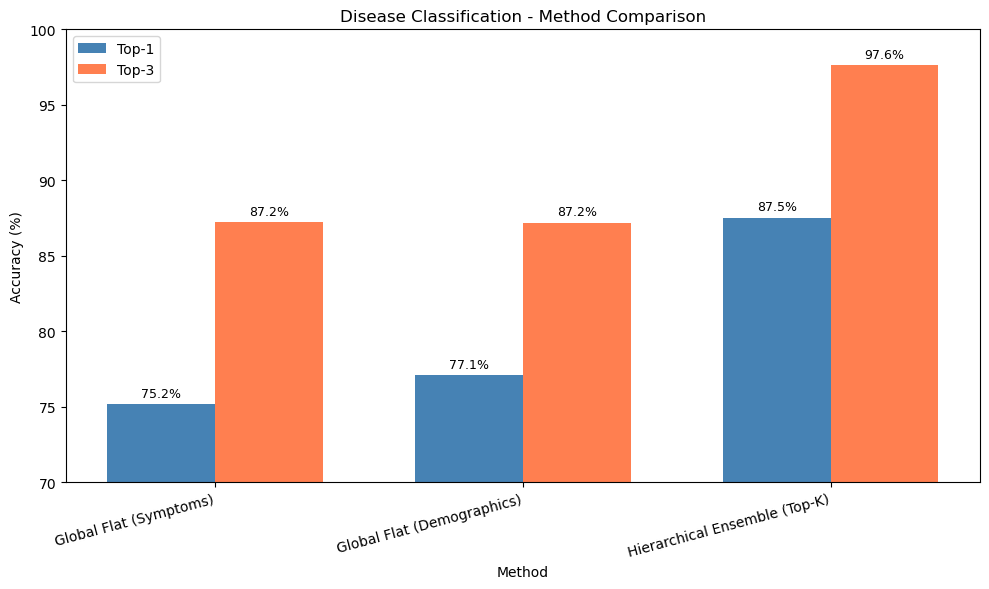

In [24]:
# Visualization
plt.figure(figsize=(10,6))
x = np.arange(len(res_df))
width = 0.35

plt.bar(x - width/2, res_df['Top-1 Accuracy'], width, label='Top-1', color='steelblue')
plt.bar(x + width/2, res_df['Top-3 Accuracy'], width, label='Top-3', color='coral')

plt.xlabel('Method')
plt.ylabel('Accuracy (%)')
plt.title('Disease Classification - Method Comparison')
plt.xticks(x, res_df['Method'], rotation=15, ha='right')
plt.legend()
plt.ylim(70, 100)

for i, (t1, t3) in enumerate(zip(res_df['Top-1 Accuracy'], res_df['Top-3 Accuracy'])):
    plt.text(i - width/2, t1 + 0.5, f'{t1:.1f}%', ha='center', fontsize=9)
    plt.text(i + width/2, t3 + 0.5, f'{t3:.1f}%', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

---
# Part 5: Save Models

In [25]:
# Create checkpoints directory
checkpoint_dir = project_root / "models" / "checkpoints"
checkpoint_dir.mkdir(exist_ok=True)

# Save original models
cat_clf_orig.save(str(checkpoint_dir / "category_classifier_symptoms.pkl"))
dis_clf_orig.save(str(checkpoint_dir / "disease_classifier_symptoms.pkl"))

# Save demographics models
cat_clf_demo.save(str(checkpoint_dir / "category_classifier_demographics.pkl"))
dis_clf_demo.save(str(checkpoint_dir / "disease_classifier_demographics.pkl"))

# Save encoders
joblib.dump(category_encoder, checkpoint_dir / "category_encoder.pkl")
joblib.dump(disease_encoder, checkpoint_dir / "disease_encoder.pkl")

# Save feature columns
with open(checkpoint_dir / "feature_columns.json", "w") as f:
    json.dump(symptom_cols, f)
with open(checkpoint_dir / "demo_feature_columns.json", "w") as f:
    json.dump(demo_feature_cols, f)

# Save training config
config = {
    'min_samples_per_disease': MIN_SAMPLES_PER_DISEASE,
    'n_diseases': len(disease_encoder.classes_),
    'n_categories': len(category_encoder.classes_),
    'n_symptoms': len(symptom_cols),
}
with open(checkpoint_dir / "training_config.json", "w") as f:
    json.dump(config, f, indent=2)

print(f"Models saved to {checkpoint_dir}")
for f in sorted(checkpoint_dir.glob('*')):
    print(f"  - {f.name}")

Models saved to c:\Users\henry\Desktop\Programming\Python\Multimodal_Diagnosis\models\checkpoints
  - category_classifier_demographics.pkl
  - category_classifier_symptoms.pkl
  - category_encoder.pkl
  - demo_feature_columns.json
  - disease_classifier_demographics.pkl
  - disease_classifier_symptoms.pkl
  - disease_encoder.pkl
  - feature_columns.json
  - semantic_model_comparison_results.json
  - training_config.json


---
# Part 6: End-to-End Test

In [26]:
from models.architectures.semantic_symptom_encoder import SemanticSymptomEncoder

# Sex-specific filters
FEMALE_ONLY_KEYWORDS = {
    'menstrual', 'menstruation', 'ovulation', 'vaginal', 'uterine', 
    'ovary', 'ovarian', 'period', 'cervical', 'cervix', 'pregnancy',
    'pregnant', 'endometri', 'mittelschmerz', 'polycystic ovarian'
}

MALE_ONLY_KEYWORDS = {
    'prostate', 'testicular', 'erectile', 'penile', 'testicle', 
    'scrotum', 'prostatic'
}

def filter_by_sex(items, sex):
    """Remove symptoms/diseases impossible for given sex."""
    if sex is None:
        return items
    filtered = []
    for item in items:
        item_lower = item.lower()
        if sex == 'M':
            if not any(kw in item_lower for kw in FEMALE_ONLY_KEYWORDS):
                filtered.append(item)
        elif sex == 'F':
            if not any(kw in item_lower for kw in MALE_ONLY_KEYWORDS):
                filtered.append(item)
        else:
            filtered.append(item)
    return filtered

def select_symptoms_dynamic(scores, symptom_names, min_threshold=0.42, 
                           max_symptoms=12, gap_ratio=0.88):
    """
    Select symptoms using dynamic thresholding.
    Stops when score drops significantly from previous.
    """
    sorted_indices = np.argsort(scores)[::-1]
    selected = []
    confidence = {}
    
    prev_score = None
    for idx in sorted_indices[:max_symptoms * 2]:
        score = float(scores[idx])
        symptom = symptom_names[idx]
        
        if score < min_threshold:
            break
        
        if prev_score is not None and score < prev_score * gap_ratio:
            if len(selected) < 3 or score < prev_score * (gap_ratio - 0.05):
                break
        
        selected.append(symptom)
        confidence[symptom] = score
        prev_score = score
        
        if len(selected) >= max_symptoms:
            break
    
    return selected, confidence

# Initialize with lower base threshold - we filter dynamically
symptom_encoder = SemanticSymptomEncoder(model_name="multi-qa-mpnet-base-dot-v1")

def predict_disease_improved(symptom_text, age=None, sex=None, top_k=5):
    """
    Improved end-to-end prediction with dynamic thresholding and sex filtering.
    """
    print(f"\n{'='*60}")
    print(f"Input: \"{symptom_text}\"")
    if age is not None and sex is not None:
        print(f"Demographics: age={age}, sex={sex}")
    print('='*60)
    
    # Get symptom scores
    result = symptom_encoder.encode_symptoms(symptom_text, return_all_scores=True)
    all_scores = result['all_scores']
    
    # Dynamic selection
    detected, scores = select_symptoms_dynamic(
        all_scores, symptom_encoder.symptoms,
        min_threshold=0.45,   # Slightly higher
        max_symptoms=8,       # Fewer symptoms
        gap_ratio=0.92        # Stricter gap
    )
    
    # Filter by sex
    detected = filter_by_sex(detected, sex)
    
    print(f"\n📋 Detected {len(detected)} symptoms:")
    for sym in detected:
        print(f"   • {sym} ({scores.get(sym, 0):.3f})")
    
    # Build feature vector
    symptom_vec = np.zeros(len(symptom_cols))
    for sym in detected:
        if sym in symptom_cols:
            symptom_vec[symptom_cols.index(sym)] = 1
    
    print(f"   (Mapped to {int(symptom_vec.sum())} feature columns)")
    
    # ========== ORIGINAL MODEL ==========
    orig_proba = dis_clf_orig.predict_proba([symptom_vec])[0]
    top_orig = np.argsort(orig_proba)[::-1][:top_k]
    
    print(f"\n🔷 Original Model (Symptoms Only) Top-{top_k}:")
    for idx in top_orig:
        print(f"   {disease_encoder.classes_[idx]}: {orig_proba[idx]*100:.1f}%")
    
    # ========== DEMOGRAPHICS MODEL ==========
    if age is not None and sex is not None:
        demo_vec = np.append(symptom_vec, [age/100.0, 1 if sex=='M' else 0])
        demo_proba = dis_clf_demo.predict_proba([demo_vec])[0]
        top_demo = np.argsort(demo_proba)[::-1][:top_k]
        
        print(f"\n🔶 Demographics Model (Symptoms+Age+Sex) Top-{top_k}:")
        for idx in top_demo:
            print(f"   {disease_encoder.classes_[idx]}: {demo_proba[idx]*100:.1f}%")
        
        # ========== HIERARCHICAL ENSEMBLE ==========
        cat_proba = cat_clf_demo.predict_proba([demo_vec])[0]
        cat_names = category_encoder.classes_
        cat_ranking = np.argsort(cat_proba)[::-1]
        
        print(f"\n📂 Category Routing:")
        for idx in cat_ranking[:3]:
            print(f"   {cat_names[idx]}: {cat_proba[idx]*100:.1f}%")
        
        # Ensemble prediction with sex filtering
        ensemble_probs = np.zeros(len(disease_encoder.classes_))
        
        for i, cat_name in enumerate(cat_names):
            model = specialist_models.get(cat_name)
            if model is None or cat_proba[i] <= 0.01:
                continue
            
            local_probs = model.predict_proba([demo_vec])[0]
            local_classes = model.diseases
            
            for local_idx, global_dis_idx in enumerate(local_classes):
                # CRITICAL: Filter sex-impossible diseases
                disease_name = disease_encoder.classes_[global_dis_idx].lower()
                if sex == 'M' and any(kw in disease_name for kw in FEMALE_ONLY_KEYWORDS):
                    continue
                if sex == 'F' and any(kw in disease_name for kw in MALE_ONLY_KEYWORDS):
                    continue
                
                ensemble_probs[global_dis_idx] += local_probs[local_idx] * cat_proba[i]
        
        top_ensemble = np.argsort(ensemble_probs)[::-1][:top_k]
        
        print(f"\n🏆 Hierarchical Ensemble Top-{top_k}:")
        for idx in top_ensemble:
            print(f"   {disease_encoder.classes_[idx]}: {ensemble_probs[idx]*100:.1f}%")
    
    return detected

[Encoder] Loading model: multi-qa-mpnet-base-dot-v1
[Encoder] Loaded cached symptom embeddings
[Encoder] Initialized with 454 symptoms


In [27]:
print("="*70)
print("VALIDATED TEST SUITE (Diseases in Training Data)")
print("="*70)
# --- Cardiovascular ---
print("\n--- Test 1: TIA / Stroke symptoms ---")
predict_disease_improved(
    "sudden weakness on one side, slurred speech, confusion, dizziness",
    age=70, sex='M'
)
# --- Genitourinary ---
print("\n--- Test 2: UTI / Pyelonephritis symptoms ---")
predict_disease_improved(
    "burning urination, fever, back pain, frequent urination",
    age=30, sex='F'
)
# --- Respiratory ---
print("\n--- Test 3: Asthma symptoms ---")
predict_disease_improved(
    "wheezing, difficulty breathing, chest tightness, coughing at night",
    age=25, sex='F'
)
# --- Infectious ---
print("\n--- Test 4: Mononucleosis symptoms ---")
predict_disease_improved(
    "extreme fatigue, sore throat, swollen lymph nodes, fever",
    age=19, sex='M'
)
# --- Musculoskeletal ---
print("\n--- Test 5: Fibromyalgia symptoms ---")
predict_disease_improved(
    "widespread pain, fatigue, sleep problems, memory issues, tender points",
    age=42, sex='F'
)
# --- Endocrine ---
print("\n--- Test 6: Hashimoto / Thyroid symptoms ---")
predict_disease_improved(
    "fatigue, weight gain, feeling cold, dry skin, hair loss, constipation",
    age=45, sex='F'
)
# --- Gastrointestinal ---
print("\n--- Test 7: Cirrhosis symptoms ---")
predict_disease_improved(
    "jaundice, abdominal swelling, fatigue, easy bruising, confusion",
    age=55, sex='M'
)
# --- Mental Health ---
print("\n--- Test 8: Panic Disorder symptoms ---")
predict_disease_improved(
    "sudden intense fear, racing heart, sweating, trembling, feeling of doom",
    age=28, sex='F'
)
# --- Neurological ---
print("\n--- Test 9: Restless Leg Syndrome ---")
predict_disease_improved(
    "uncomfortable leg sensations, urge to move legs, worse at night, relief with movement",
    age=50, sex='M'
)
# --- Hematology ---
print("\n--- Test 10: Lymphoma symptoms ---")
predict_disease_improved(
    "painless swollen lymph nodes, night sweats, unexplained weight loss, fatigue, fever",
    age=40, sex='M'
)

VALIDATED TEST SUITE (Diseases in Training Data)

--- Test 1: TIA / Stroke symptoms ---

Input: "sudden weakness on one side, slurred speech, confusion, dizziness"
Demographics: age=70, sex=M

📋 Detected 4 symptoms:
   • weakness (0.900)
   • confusion (0.900)
   • slurred speech (0.900)
   • dizziness (0.900)
   (Mapped to 4 feature columns)

🔷 Original Model (Symptoms Only) Top-5:
   hemiplegia: 48.4%
   acute fatty liver of pregnancy (aflp): 0.2%
   hypercalcemia: 0.1%
   stroke: 0.1%
   diabetes insipidus: 0.1%

🔶 Demographics Model (Symptoms+Age+Sex) Top-5:
   hemiplegia: 96.2%
   hypercalcemia: 0.2%
   volvulus: 0.0%
   stroke: 0.0%
   dysthymic disorder: 0.0%

📂 Category Routing:
   Cardiovascular and Circulatory: 41.3%
   Neurological Disorders: 22.1%
   Hematology and Oncology: 15.2%

🏆 Hierarchical Ensemble Top-5:
   stroke: 41.1%
   aplastic anemia: 15.1%
   myasthenia gravis: 8.9%
   hypercalcemia: 8.2%
   cerebral edema: 4.7%

--- Test 2: UTI / Pyelonephritis symptoms ---


['fever',
 'night sweats',
 'fatigue',
 'pain',
 'weight loss',
 'swollen lymph nodes']

In [28]:
# View all 656 diseases grouped by category
print(f"Total diseases: {len(disease_encoder.classes_)}")
print(f"\nAll disease categories: {list(category_encoder.classes_)}")

# Sample diseases from each category
for cat in category_encoder.classes_:
    cat_diseases = df_demo[df_demo['disease_category'] == cat]['diseases'].unique()[:5]
    print(f"\n{cat} ({len(df_demo[df_demo['disease_category'] == cat]['diseases'].unique())} diseases):")
    for d in cat_diseases:
        print(f"  • {d}")

Total diseases: 656

All disease categories: ['Cardiovascular and Circulatory', 'Dermatological', 'Endocrine and Metabolic', 'Gastrointestinal and Hepatic', 'Genitourinary and Reproductive', 'Hematology and Oncology', 'Infectious Diseases', 'Mental and Behavioral Health', 'Musculoskeletal', 'Neurological Disorders', 'Obstetrics and Neonatal', 'Ophthalmology and ENT', 'Respiratory System', 'Unknown Type']

Cardiovascular and Circulatory (48 diseases):
  • sick sinus syndrome
  • transient ischemic attack
  • thoracic aortic aneurysm
  • subdural hemorrhage
  • thrombophlebitis

Dermatological (35 diseases):
  • hyperhidrosis
  • pilonidal cyst
  • alopecia
  • herpangina
  • pemphigus

Endocrine and Metabolic (44 diseases):
  • metabolic disorder
  • diabetic retinopathy
  • pituitary adenoma
  • hashimoto thyroiditis
  • hyperkalemia

Gastrointestinal and Hepatic (52 diseases):
  • pyloric stenosis
  • liver cancer
  • choledocholithiasis
  • cirrhosis
  • ischemia of the bowel

Genito

---
# Summary

**Models Trained:**
- Category Classifier (Original): 14 classes
- Category Classifier (Demographics): 14 classes
- Disease Classifier (Original): 656 classes
- Disease Classifier (Demographics): 656 classes
- Specialist Models: 14 category-specific disease classifiers

**Key Results:**
- Demographics improve Top-1 disease accuracy by ~2%
- Hierarchical ensemble further improves Top-1 accuracy
- Top-3 routing strategy captures uncertain category predictions

In [29]:
print("✅ Disease Classifier Training Complete!")
print(f"\nModels saved to: {checkpoint_dir}")

✅ Disease Classifier Training Complete!

Models saved to: c:\Users\henry\Desktop\Programming\Python\Multimodal_Diagnosis\models\checkpoints


In [31]:
# === DEBUGGING CELL ===
def debug_predict_disease(symptom_text: str, age: int = None, sex: str = None, top_k: int = 5):
    """
    Debug version to understand what's going wrong
    """
    # Extract symptoms
    # Extract symptoms
    result = symptom_encoder.encode_symptoms(symptom_text)
    # Use helper method to get top symptoms from the vector
    # Returns list of (symptom, score), so we extract just the symptom names
    top_items = symptom_encoder.get_top_symptoms(result['symptom_vector'], top_k=10, threshold=0.0)
    detected = [item[0] for item in top_items]
    
    print(f"Input: \"{symptom_text}\"")
    print(f"Demographics: age={age}, sex={sex}")
    print(f"\n=== SYMPTOM DETECTION DEBUG ===")
    print(f"Detected {len(detected)} symptoms:")
    for sym in detected:
        print(f"  - {sym}")
    
    # Check how many match our feature columns
    matched = [s for s in detected if s in symptom_cols]
    print(f"\nMatched to feature columns: {len(matched)} / {len(detected)}")
    print(f"Matched symptoms: {matched}")
    
    # Build feature vector
    symptom_vec = np.zeros(len(symptom_cols))
    for sym in detected:
        if sym in symptom_cols:
            symptom_vec[symptom_cols.index(sym)] = 1
    
    print(f"\nActive features in vector: {int(symptom_vec.sum())}")
    
    if age is not None and sex is not None:
        demo_vec = np.append(symptom_vec, [age/100.0, 1 if sex=='M' else 0])
        
        # === DEBUG CATEGORY PREDICTIONS ===
        print(f"\n=== CATEGORY ROUTING DEBUG ===")
        cat_probs = cat_clf_demo.predict_proba([demo_vec])[0]
        cat_names_map = category_encoder.classes_
        
        # Show all category probabilities
        cat_ranking = np.argsort(cat_probs)[::-1]
        for idx in cat_ranking:
            if cat_probs[idx] > 0.01:  # Only show >1%
                print(f"  {cat_names_map[idx]}: {cat_probs[idx]*100:.1f}%")
        
        # === DEBUG SPECIALIST OUTPUTS ===
        print(f"\n=== SPECIALIST PREDICTIONS DEBUG ===")
        top_cat_idx = cat_ranking[0]
        top_cat_name = cat_names_map[top_cat_idx]
        print(f"Top category: {top_cat_name} ({cat_probs[top_cat_idx]*100:.1f}%)")
        
        if top_cat_name in specialist_models:
            model = specialist_models[top_cat_name]
            print(f"Specialist diseases: {len(model.diseases)} diseases")
            
            local_probs = model.predict_proba([demo_vec])[0]
            top_local = np.argsort(local_probs)[::-1][:5]
            
            print(f"\nSpecialist top-5 predictions:")
            for local_idx in top_local:
                global_idx = model.diseases[local_idx]
                disease_name = disease_encoder.classes_[global_idx]
                print(f"  - {disease_name}: {local_probs[local_idx]*100:.1f}%")

# Run debug
debug_predict_disease("difficulty urinating, weak stream, frequent urination at night", age=65, sex='M')

Input: "difficulty urinating, weak stream, frequent urination at night"
Demographics: age=65, sex=M

=== SYMPTOM DETECTION DEBUG ===
Detected 10 symptoms:
  - frequent urination
  - excessive urination at night
  - involuntary urination
  - painful urination
  - dark urine
  - retention of urine
  - blood in urine
  - symptoms of bladder
  - low urine output
  - diarrhea

Matched to feature columns: 10 / 10
Matched symptoms: ['frequent urination', 'excessive urination at night', 'involuntary urination', 'painful urination', 'dark urine', 'retention of urine', 'blood in urine', 'symptoms of bladder', 'low urine output', 'diarrhea']

Active features in vector: 10

=== CATEGORY ROUTING DEBUG ===
  Genitourinary and Reproductive: 92.8%
  Unknown Type: 5.0%

=== SPECIALIST PREDICTIONS DEBUG ===
Top category: Genitourinary and Reproductive (92.8%)
Specialist diseases: 79 diseases

Specialist top-5 predictions:
  - mittelschmerz: 98.2%
  - benign prostatic hyperplasia (bph): 1.6%
  - urge inc